### CRYPTO MEAN REVERSION PAIRS TRADING WITH INCLUSION OF A KALMAN FILTER

In this notebook we are going look at the concept of building a trading strategy backtest based on mean reverting, co-integrated pairs of crypto currencies. So to restate the theory in in terms of US equities, stocks that are statistically co-integrated move in a way that means when their prices start to diverge by a certain amount (i.e. the spread between the 2 stocks prices increases), we would expect that divergence to
eventually revert back to the mean. In this instance we would look to sell the outperforming stock,and buy the under performing stock in our expectance that the under performing stock would eventually “catch up” with the overpeforming stock and rise in price, or vice versa the overperforming stock would in time suffer from the same downward pressure of the underperforming stock and fall in relative value.

Hence, pairs trading is a market neutral trading strategy enabling traders to profit from virtually any market conditions: Bull Market, Bear Market, or Sideways Market.

So in our search for co-integrated Altcoins, economic theory would suggest that we are more likley to find pairs of that are driven by the same factors, if we search for pairs that are drawn from similar/the same blockchain & technology. After all, it is logical to expect
2 Altcoins with similar blockchain tech and use case could be considered similar products, to be at the mercy of the same general ups and downs of the volatile crypto market.

### Kalman Filter

So what is a Kalman Filter? Well this site (http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/) explains and states the following:

You can use a Kalman filter in any place where you have uncertain information about some dynamic system, and you can make an educated guess about what the system is going to do next. Even if messy reality comes along and interferes with the clean motion you guessed about, the Kalman filter will often do a very good job of figuring out what actually happened. And it can take advantage of correlations between crazy phenomena that you maybe wouldn’t have thought to exploit!

Kalman filters are ideal for systems which are continuously changing. They have the advantage that they are light on memory (they don’t need to keep any history other than the previous state), and they are very fast, making them well suited for real time problems and embedded systems.

So lets start to import the relevant modules we will need for our strategy backtest:

In [1]:
from time import time
import numpy as np                  
import matplotlib.pyplot as plt   
import datetime as dt  
import pandas as pd
import math
import os.path
import time
import json
import requests
from bitmex import bitmex
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook 
import seaborn as sns
import matplotlib as mpl
mpl.style.use('seaborn')
import statsmodels.api as sm
from pykalman import KalmanFilter
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
import ffn

In [3]:
### CONSTANTS
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 750
binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)

In [4]:
### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('30 Nov 2017', '%d %b %Y')
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    return old, new

## Get Historical Pricing from Binance 
def get_all_binance(symbol, kline_size, save = False):
    filename = 'Binance_%s_%s_data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('30 Nov 2017', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data = data.drop('ignore', axis=1)
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    print('All caught up..!')
    return data_df

In [5]:
# For all Binance USDT symbols
# https://steemit.com/money/@marketstack/visualizing-alt-coin-correlation
symbols = json.loads(requests.get("https://api.binance.com/api/v1/exchangeInfo").text)
symbols = [symbol['symbol'] for symbol in symbols['symbols'] if symbol['quoteAsset'] == 'BTC']

What we're left with here is a list of any pair with BTC as the quote side of the pair. We will combine this data with the price history of BTC/USDT to create time series for each cryptocurrency quoted in USDT instead of BTC.

To do this we'll use our get_bars function to retrieve the data for BTC/USDT

In [6]:
btcusdt = get_all_binance('BTCUSDT', '1d', save = False)

All caught up..!


In [7]:
# Downloading all Altcoin price data
price_data = []
new_symbols = []
binance_symbols = symbols
for symbol in binance_symbols:
    data = get_all_binance(symbol, '1d', save = False)
    new_symbols.append(symbol.replace('BTC','USDT')) 
    price_data.append(data['close'].astype('float') * btcusdt['close'].astype('float'))

All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up.

All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up.

In [8]:
# Merge all price data into a single dataframe and drop all NaNs
combo = pd.concat(price_data, axis = 1)
combo.columns = binance_symbols
combo = combo.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)
combo.head()

,ETHBTC,LTCBTC,BNBBTC,NEOBTC,GASBTC,MCOBTC,WTCBTC,LRCBTC,QTUMBTC,YOYOBTC,...,BTSBTC,XZCBTC,LSKBTC,TNTBTC,FUELBTC,MANABTC,BCDBTC,DGDBTC,ADXBTC,ADABTC
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-11-30,429.480443,85.412012,1.967792,32.557119,18.595634,5.696758,6.670421,0.203273,11.875625,0.087567,...,0.131645,35.420256,7.408737,0.073202,0.038470,0.015152,50.611610,98.556862,1.082384,0.118461
2017-12-01,457.166427,97.090042,2.053728,35.583867,19.075109,6.232568,8.275298,0.232481,12.680796,0.128749,...,0.145463,37.621852,7.715229,0.077853,0.044642,0.016067,56.006850,105.188067,1.185590,0.131552
2017-12-02,457.140840,98.805061,2.068013,34.967822,18.883277,6.120186,9.637659,0.255697,12.501731,0.132314,...,0.136670,37.526974,7.752598,0.076339,0.047916,0.017206,51.008807,100.438562,1.166102,0.132096
2017-12-03,459.356133,99.718277,2.288909,36.566718,19.293828,6.688081,9.289844,0.284495,12.706237,0.124048,...,0.143922,37.314800,7.764426,0.078604,0.047565,0.017083,50.021037,108.762259,1.270847,0.131863
2017-12-04,465.255799,103.226785,2.541590,41.869664,21.861152,12.748479,9.147410,0.316454,13.420061,0.224169,...,0.175538,39.889655,8.808145,0.083716,0.044811,0.018758,47.485479,119.831071,1.534218,0.136516


Plot the resulting DataFrame of price data just to make sure we have what we need and as a quick sanity check:

In [9]:
num_coins = len(combo.columns)
print('Number of Altcoins =', num_coins) 

Number of Altcoins = 69


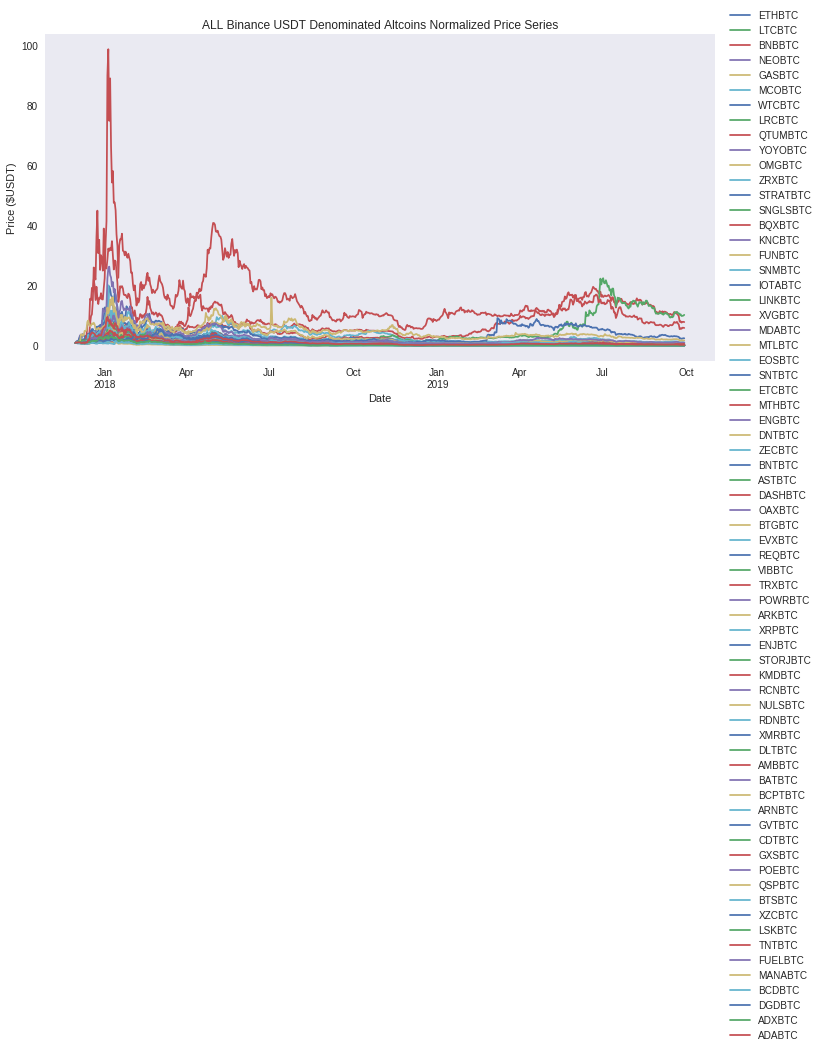

In [10]:
combo.div(combo.iloc[0,:]).plot(figsize=(12, 6))# Normalize Prices 
plt.title('ALL Binance USDT Denominated Altcoins Normalized Price Series')
plt.xlabel('Date')
plt.ylabel('Price ($USDT)')
plt.grid(b=None, which=u'major', axis=u'both')
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show();

Ok so it looks from the chart as if we have around price data downloaded for 69 Altcoins; this should be more than enough to find at least a couple of co-integrated pairs to run our backtest over.

We will now define a quick function that will run our Altcoins, combining them into pairs one by one and running co-integration tests on each pair. That result will then be stored in a matrix that we initialise,
and then we will be able to plot that matrix as a heatmap. Also, if the co-integration test meets our threshold statistical significance (in our case 5%), then that pair of Altcoin tickers will be stored in a list for later retrieval.

In [11]:
# Source: https://pythonforfinance.net/2018/07/04/mean-reversion-pairs-trading-with-inclusion-of-a-kalman-filter/
# NOTE CRITICAL LEVEL HAS BEEN SET TO 5% FOR COINTEGRATION TEST
def find_cointegrated_pairs(dataframe, critial_level = 0.05):
    n = dataframe.shape[1] # the length of dateframe
    pvalue_matrix = np.ones((n, n)) # initialize the matrix of p
    keys = dataframe.columns # get the column names
    pairs = [] # initilize the list for cointegration
    for i in range(n):
        for j in range(i+1, n): # for j bigger than i
            stock1 = dataframe[keys[i]] # obtain the price of "stock1"
            stock2 = dataframe[keys[j]]# obtain the price of "stock2"
            result = sm.tsa.stattools.coint(stock1, stock2) # get conintegration
            pvalue = result[1] # get the pvalue
            pvalue_matrix[i, j] = pvalue
            if pvalue < critial_level: # if p-value less than the critical level
                pairs.append((keys[i], keys[j], pvalue)) # record the contract with that p-value
    return pvalue_matrix, pairs

Let’s now run our data through our function, save the results and plot the heatmap:

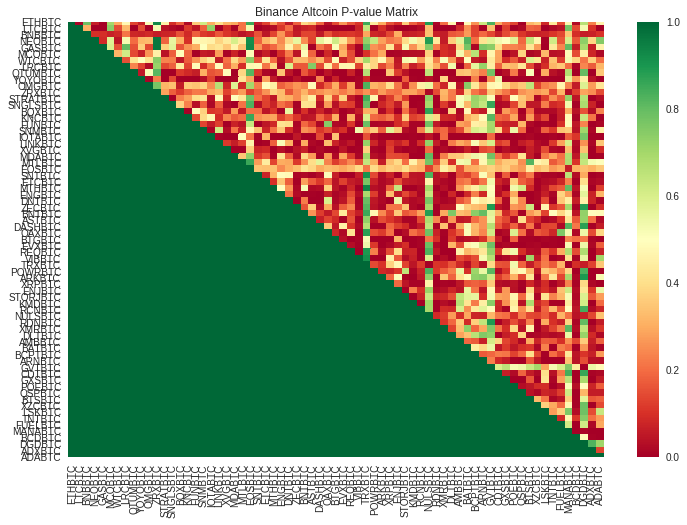

In [12]:
df = combo

binance_symbols = df.columns

# Set up the split point for our "training data" on which to perform the co-integration test (the remaining dat awill be fed to our backtest function)
split = int(len(df) * 0.4)

# Run our dataframe (up to the split point) of ticker price data through our co-integration function and store results
pvalue_matrix,pairs = find_cointegrated_pairs(df[:split])

# Convert our matrix of stored results into a DataFrame
pvalue_matrix_df = pd.DataFrame(pvalue_matrix)

# Use Seaborn to plot a heatmap of our results matrix
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(pvalue_matrix_df,xticklabels=binance_symbols,yticklabels=binance_symbols,ax=ax,cmap="RdYlGn")
plt.title('Binance Altcoin P-value Matrix')
plt.show();

So we can see from the very dark red squares that it looks as though there are indeed a few pairs of Altcoins who’s co-integration score is below the 5% threshold
hardcoded into the function we defined. To see more explicitly which pairs these are, let’s print out our list of stored pairs that was part of the fucntion results we stored:

In [13]:
for pair in pairs:
    print("Altcoin {} and Altcoin {} has a co-integration score of {}".format(pair[0],pair[1],round(pair[2],4)))

Altcoin ETHBTC and Altcoin LTCBTC has a co-integration score of 0.0091
Altcoin ETHBTC and Altcoin GASBTC has a co-integration score of 0.0
Altcoin ETHBTC and Altcoin KNCBTC has a co-integration score of 0.0224
Altcoin ETHBTC and Altcoin OAXBTC has a co-integration score of 0.0361
Altcoin ETHBTC and Altcoin RDNBTC has a co-integration score of 0.0126
Altcoin ETHBTC and Altcoin AMBBTC has a co-integration score of 0.011
Altcoin ETHBTC and Altcoin QSPBTC has a co-integration score of 0.0037
Altcoin ETHBTC and Altcoin BCDBTC has a co-integration score of 0.0272
Altcoin LTCBTC and Altcoin NEOBTC has a co-integration score of 0.0003
Altcoin LTCBTC and Altcoin GASBTC has a co-integration score of 0.0002
Altcoin LTCBTC and Altcoin QTUMBTC has a co-integration score of 0.0
Altcoin LTCBTC and Altcoin OMGBTC has a co-integration score of 0.0
Altcoin LTCBTC and Altcoin STRATBTC has a co-integration score of 0.0385
Altcoin LTCBTC and Altcoin SNGLSBTC has a co-integration score of 0.0222
Altcoin LTC

We will now use the “pykalman” module to set up a couple of functions that will allow us to generate Kalman filters which we will apply to our data and in turn our regression that is fed the said data.

In [14]:
def KalmanFilterAverage(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)
  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means

def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
    if halflife <= 0:
        halflife = 1
    return halflife

Now let us define our main “Backtest” function that we will run our data through. The fucntion takes one pair of tickers at a time, and then returns several outputs, namely the DataFrame of cumulative returns,
the Sharpe Ratio and the Compound Annual Growth Rate (CAGR). Once we have defined our function, we can iterate over our list of pairs and feed the relevant data, pair by pair, into the function, storing the outputs for each pair for
later use and retrieval.

In [17]:
def backtest(df,s1, s2):
    #############################################################
    # INPUT:
    # DataFrame of prices
    # s1: the symbol of contract one
    # s2: the symbol of contract two
    # x: the price series of contract one
    # y: the price series of contract two
    # OUTPUT:
    # df1['cum rets']: cumulative returns in pandas data frame
    # sharpe: Sharpe ratio
    # CAGR: Compound Annual Growth Rate
    x = df[s1]
    y = df[s2]
    
    # run regression (including Kalman Filter) to find hedge ratio and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    df1.index = pd.to_datetime(df1.index)
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))
    df1['hr'] = - state_means[:,0]
    df1['spread'] = df1.y + (df1.x * df1.hr)
    
    # calculate half life
    halflife = half_life(df1['spread'])
    
    # calculate z-score with window = half life period
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = (df1.spread-meanSpread)/stdSpread
    
    ##############################################################
    
    # trading logic
    entryZscore = 2
    exitZscore = 0
    
    #set up num units long
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0 
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad')
    
    #set up num units short 
    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')
    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)
    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    ##############################################################
    
    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0
        
    ##############################################################
    
    start_val = 1
    end_val = df1['cum rets'].iat[-1]
    start_date = df1.iloc[0].name
    end_date = df1.iloc[-1].name
    days = (end_date - start_date).days
    CAGR = (end_val / start_val) ** (252.0/days) - 1
    #CAGR = round(((float(end_val) / float(start_val)) ** (252.0/days)) - 1,4)
    df1[s1+ " "+s2] = df1['cum rets']
    return df1[s1+" "+s2], sharpe, CAGR

So now let’s run our full list of pairs through our Backtest function, and print out some results along the way, and finally after storing the equity curve for each pair,
produce a chart that plots out each curve.

The pair ETHBTC and AMBBTC produced a Sharpe Ratio of 2.02 and a CAGR of 0.2288
The pair LTCBTC and BQXBTC produced a Sharpe Ratio of 1.44 and a CAGR of 0.2971
The pair LTCBTC and LINKBTC produced a Sharpe Ratio of 1.31 and a CAGR of 0.3416
The pair LTCBTC and XRPBTC produced a Sharpe Ratio of 1.47 and a CAGR of 0.2918
The pair LTCBTC and ENJBTC produced a Sharpe Ratio of 1.92 and a CAGR of 0.3129
The pair LTCBTC and DLTBTC produced a Sharpe Ratio of 1.46 and a CAGR of 0.3001
The pair GASBTC and VIBBTC produced a Sharpe Ratio of 1.52 and a CAGR of 0.1581
The pair GASBTC and BCPTBTC produced a Sharpe Ratio of 1.42 and a CAGR of 0.3605
The pair MCOBTC and RDNBTC produced a Sharpe Ratio of 1.75 and a CAGR of 0.3411
The pair MCOBTC and TNTBTC produced a Sharpe Ratio of 1.5 and a CAGR of 0.4756
The pair MCOBTC and FUELBTC produced a Sharpe Ratio of 1.68 and a CAGR of 0.617
The pair WTCBTC and ENGBTC produced a Sharpe Ratio of 1.36 and a CAGR of 0.254
The pair QTUMBTC and VIBBTC produced a S

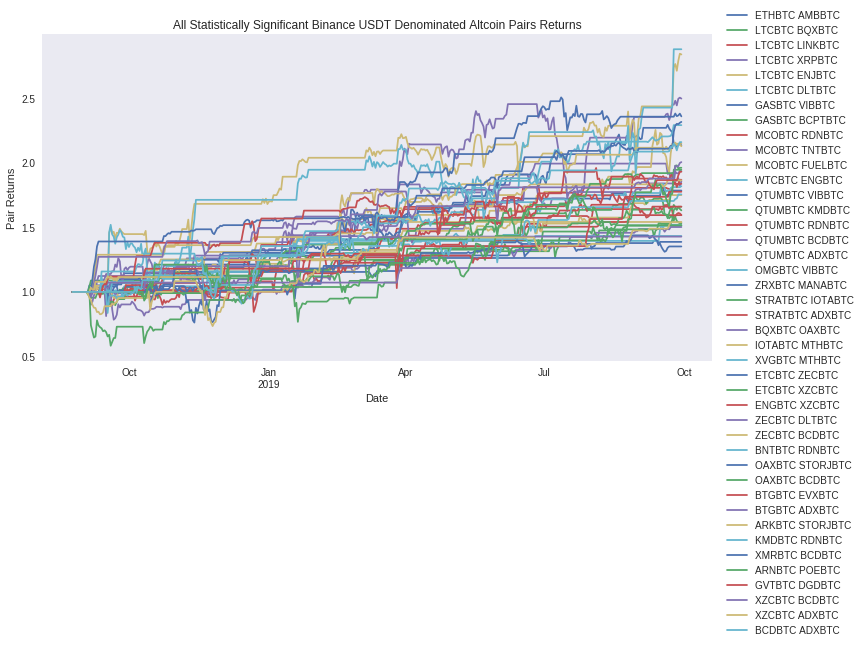

In [18]:
results = []
for pair in pairs:
    rets, sharpe,  CAGR = backtest(df[split:],pair[0],pair[1])
    if round(sharpe,2) > 1.29:
        results.append(rets)
        print("The pair {} and {} produced a Sharpe Ratio of {} and a CAGR of {}".format(pair[0],pair[1],round(sharpe,2),round(CAGR,4)))
        #print("The pair {} and {} produced a Sharpe Ratio of {} and a CAGR of {}".format(pair[0],pair[1],round(sharpe,2),round(CAGR,4)))
        rets.plot(figsize=(12,6),legend=True)
        plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
        plt.grid(b=None, which=u'major', axis=u'both')
        plt.title('All Statistically Significant Binance USDT Denominated Altcoin Pairs Returns')
        plt.xlabel('Date')
        plt.ylabel('Pair Returns');

Now we run a few extra lines of code to combine, equally weight, and print our our final equity curve:

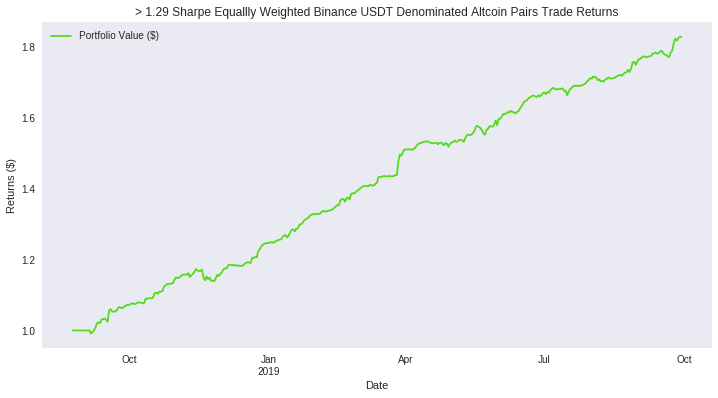

In [19]:
#concatenate together the individual equity curves into a single DataFrame
results_df = pd.concat(results,axis=1).dropna()

#equally weight each equity curve by dividing each by the number of pairs held in the DataFrame
results_df /= len(results_df.columns)

#sum up the equally weighted equity curves to get our final equity curve
final_res = results_df.sum(axis=1)

#plot the chart of our final equity curve
final_res.plot(label='Portfolio Value ($)',color='#50db14', figsize=(12,6))
plt.title('> 1.29 Sharpe Equallly Weighted Binance USDT Denominated Altcoin Pairs Trade Returns')
plt.grid(b=None, which=u'major', axis=u'both')
plt.xlabel('Date')
plt.ylabel('Returns ($)')
plt.legend();

In [20]:
num_coins = len(results_df.columns)
print('Number of Pairs =', num_coins)

Number of Pairs = 42


### Underwater Plot

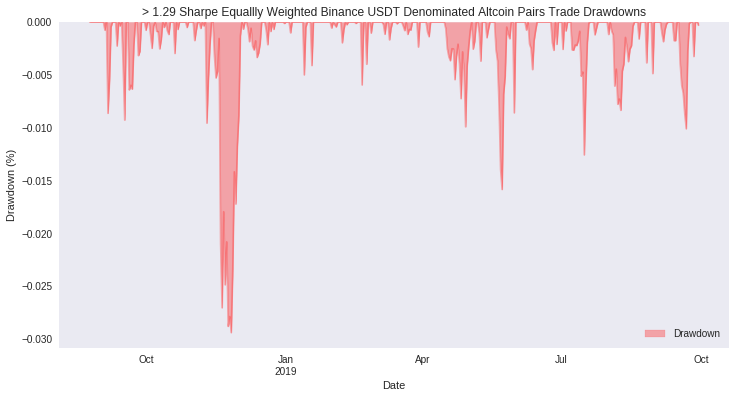

In [21]:
ffn.to_drawdown_series(final_res).plot(kind = 'area',alpha=.4,label='Drawdown',color='#ff3838',figsize=(12,6),grid=False)
plt.title('> 1.29 Sharpe Equallly Weighted Binance USDT Denominated Altcoin Pairs Trade Drawdowns')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.legend(loc='lower right');

### Total Returns Performance

In [22]:
perf = final_res.calc_stats()
perf.display()

Stats for None from 2018-08-25 00:00:00 - 2019-09-29 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
82.68%              5.76  73.37%  -2.94%

Annualized Returns:
mtd    3m     6m      ytd     1y      3y      5y    10y    incep.
-----  -----  ------  ------  ------  ------  ----  -----  --------
3.96%  9.83%  22.41%  46.63%  70.70%  73.37%  -     -      73.37%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  5.76     6.78       -
mean    38.21%   57.25%     46.63%
vol     6.63%    8.45%      -
skew    1.44     -0.13      -
kurt    10.81    -1.37      -
best    3.15%    8.39%      46.63%
worst   -1.94%   1.08%      46.63%

Drawdowns:
max     avg       # days
------  ------  --------
-2.94%  -0.34%      2.74

Misc:
---------------  -------
avg. up month    4.77%
avg. down month  -
up year %        100.00%
12m up %         100.00%
------------

### Monthly Returns Performance

In [23]:
perf.display_monthly_returns()

  Year    Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct    Nov    Dec    YTD
------  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----
  2018   0      0      0      0       0     0      0      0      7.22   6.71   1.34   7.45  24.59
  2019   6.52   4.98   8.39   1.08    3.4   5.74   2.54   2.69   3.96   0      0      0     46.63


In [24]:
perf.stats

start                    2018-08-25 00:00:00
end                      2019-09-29 00:00:00
rf                                         0
total_return                        0.826827
cagr                                0.733654
max_drawdown                      -0.0293851
calmar                               24.9669
mtd                                0.0396392
three_month                        0.0982915
six_month                           0.224063
ytd                                 0.466329
one_year                            0.706968
three_year                          0.733654
five_year                                NaN
ten_year                                 NaN
incep                               0.733654
daily_sharpe                         5.76273
daily_sortino                        13.6631
daily_mean                          0.382093
daily_vol                          0.0663041
daily_skew                           1.43824
daily_kurt                           10.8124
best_day  

The Sharpe Ratio is very good. Also take into consideration trading cost for crypto currency is very minimal but was not factored in these performance stats. The testing period was only from August 2018 until September 29th 2019 only looking at specific pairs returns when traded in the training period that was able to yield a greater than 1.29 sharpe ratio. Then creating an equal weight portfolio of those high yielding sharpe pairs to trade in the test period. Cummulative returns were almost 82% for about 1yr with little to no drawdown (fucking impressive). 